In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load and preprocess MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
data_loader = DataLoader(train_dataset + test_dataset, batch_size=256, shuffle=False)

all_imgs = []
all_labels = []
for imgs, labels in data_loader:
    all_imgs.append(imgs)
    all_labels.append(labels)
x = torch.cat(all_imgs).to(device)
y = torch.cat(all_labels).cpu().numpy()

In [4]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoencoder().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [5]:
# Train the model
for epoch in range(20):
    total_loss = 0
    for imgs, _ in DataLoader(train_dataset + test_dataset, batch_size=256, shuffle=True):
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 26.3417
Epoch 2, Loss: 17.9418
Epoch 3, Loss: 17.5048
Epoch 4, Loss: 17.2772
Epoch 5, Loss: 17.1226
Epoch 6, Loss: 16.9923
Epoch 7, Loss: 16.9036
Epoch 8, Loss: 16.8220
Epoch 9, Loss: 16.7783
Epoch 10, Loss: 16.7261
Epoch 11, Loss: 16.6901
Epoch 12, Loss: 16.6531
Epoch 13, Loss: 16.6290
Epoch 14, Loss: 16.5952
Epoch 15, Loss: 16.5882
Epoch 16, Loss: 16.5562
Epoch 17, Loss: 16.5291
Epoch 18, Loss: 16.5179
Epoch 19, Loss: 16.5108
Epoch 20, Loss: 16.4936


In [6]:
# Extract encoded features
model.eval()
with torch.no_grad():
    encoded_imgs = model.encoder(x).cpu().numpy()

encoded_imgs_flat = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

In [7]:
# PCA to reduce dimensionality
pca = PCA(n_components=50)
x_pca = pca.fit_transform(encoded_imgs_flat)


In [8]:
# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_preds = kmeans.fit_predict(x_pca)

C:\Users\munta\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\munta\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [9]:
# Evaluation
ari = adjusted_rand_score(y, cluster_preds)
nmi = normalized_mutual_info_score(y, cluster_preds)
silhouette = silhouette_score(x_pca, cluster_preds)

print("\nClustering Results (KMeans on PCA of CAE features):")
print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Silhouette Score: {silhouette:.4f}")


Clustering Results (KMeans on PCA of CAE features):
ARI: 0.4296, NMI: 0.5323, Silhouette Score: 0.1108


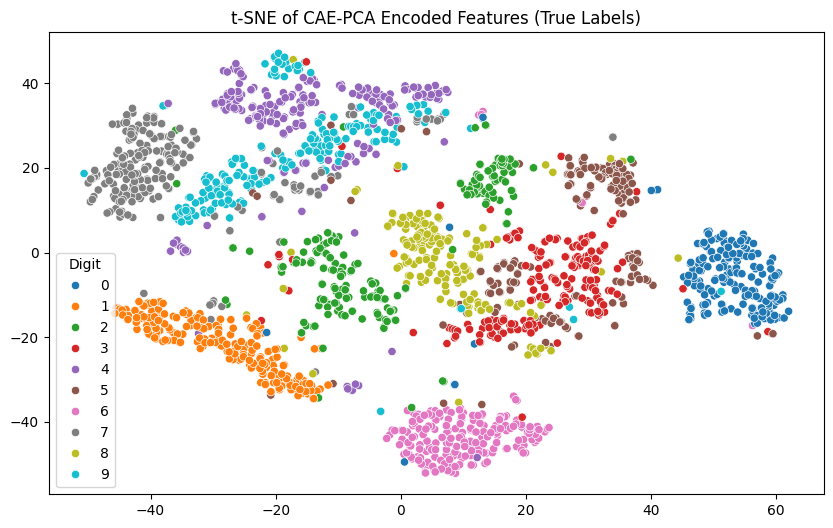

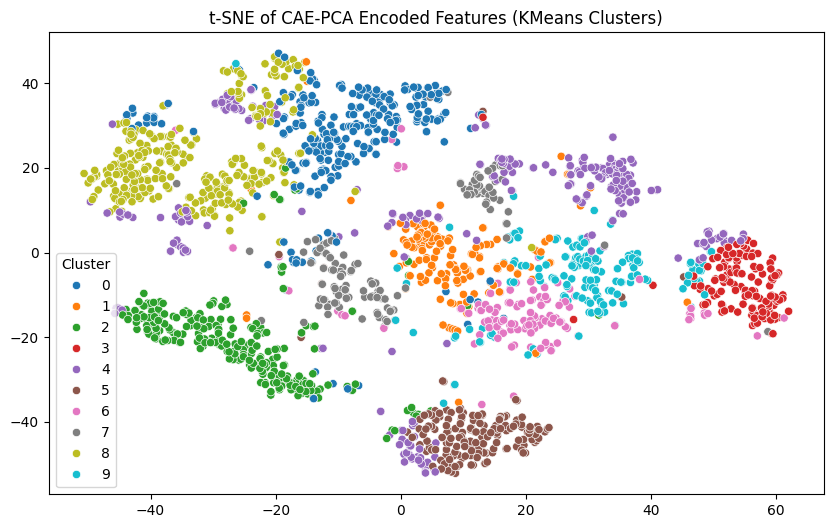

In [10]:
# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
x_tsne = tsne.fit_transform(x_pca[:2000])

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=y[:2000], palette='tab10', legend='full')
plt.title("t-SNE of CAE-PCA Encoded Features (True Labels)")
plt.legend(title='Digit')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_tsne[:, 0], y=x_tsne[:, 1], hue=cluster_preds[:2000], palette='tab10', legend='full')
plt.title("t-SNE of CAE-PCA Encoded Features (KMeans Clusters)")
plt.legend(title='Cluster')
plt.show()
